# Final Project: Automated Essay Scoring

## Submitted by - Gupta, Amit

__Introduction__ Automated Essay Scoring (AES) systems are targeted at both alleviating the workload of teachers and improving the feedback cycle in educational systems. AES systems have also
seen adoption for several high-stakes assessment, e.g., the e-rater system which has been used for TOEFL and GRE examinations. A successful AES system brings about widespread benefits to society and the education industry. Traditionally, the task of AES has been regarded as a machine learning problem which learns to approximate the marking process with supervised learning. Decades of AES research follow the same traditional supervised text regression methods in which handcrafted features are constructed and subsequently passed into a machine learning based classifier. A wide assortment of features are commonly extracted from essays. Simple and intuitive features may include essay length, sentence length. On the other hand, intricate and complex features may also be extracted, e.g.., features such as grammar correctness , readability  and textual
coherence. However, these handcrafted features are often painstakingly designed, require a lot of human involvement and usually require laborious implementation for every new feature.

In this project we will apply deep learning models to learn important features of the essay automatically, and compare the results with the state of art deep learning models.

__Dataset Description__: There are eight essay sets. Each of the sets of essays was generated from a single prompt. Selected essays range from an average length of 150 to 550 words per response. Some of the essays are dependent upon source information and others are not. All responses were written by students ranging in grade levels from Grade 7 to Grade 10. All essays were hand graded and were double-scored. Each of the eight data sets has its own unique characteristics. The variability is intended to test the limits of your scoring engine's capabilities.

The training data is provided in three formats: a tab-separated value (TSV) file, a Microsoft Excel 2010 spreadsheet, and a Microsoft Excel 2003 spreadsheet.  The current release of the training data contains essay sets 1-6.  Sets 7-8 will be released on February 10, 2012.  Each of these files contains 28 columns:

essay_id: A unique identifier for each individual student essay
essay_set: 1-8, an id for each set of essays
essay: The ascii text of a student's response
rater1_domain1: Rater 1's domain 1 score; all essays have this
rater2_domain1: Rater 2's domain 1 score; all essays have this
rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this.
domain1_score: Resolved score between the raters; all essays have this
rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this
rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this
domain2_score: Resolved score between the raters; only essays in set 2 have this
rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8

__We are using tsv training data file, and this project is focussed on one essay prompt namely "essay set 3". This is one of the harder essays to train judging by various papers. Please see the following 2 papers for all the previous work, and the state of art results.__
* Incorporating Neural Coherence Features: https://arxiv.org/abs/1711.04981
* A Siamese Bidirectional LSTM Architecture: https://www.mdpi.com/2073-8994/10/12/682

 

__Deep Learning Model__: Following are the list of techniques applied in this project
* Vectorization (tf-idf, and jointly learned embeddings) 
* Networks: Dense, CNN+Dense, LSTM+Dense, BiLSTM+Dense, CNN+LSTM+Dense, CNN+BiLSTM+Dense
* Novel NLP data augmentation techniques (not covered in class)
* * __Synonym Replacement__ (SR): Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.
* * __Random Insertion__ (RI): Find a random synonym of a random word in the sentence that is not a stop word. Insert that synonym into a random position in the sentence. Do this n times.
* * __Random Swap__ (RS): Randomly choose two words in the sentence and swap their positions. Do this n times.
* * __Random Deletion__ (RD): For each word in the sentence, randomly remove it with probability p.

To keep this notebook concise, I have shown only the results of CNN+Dense network as this 
network showed the best performance.

__Overall Results for CNN+Dense DL model__ 
* Without data augmentation: Kappa is 0.48 (for tf-idf) - 0.51 (with embeddings)
* With data augmentation: Kappa improved to 0.76 for both tf-idf and embeddings
* State of art results reported in the papers (without data augmentation) is 0.78 with Siamese BiLSTM model.

__Results for LSTM based DL models__
* Plain vanilla LSTM and BiLSTM models performed worse than CNN based models. I think the reason is essays are long (100 words), and these networks appear to not do a good job on remembering the long history.
* Tweaks to LSTM and BiLSTM models are needed as shown in the promising work in the listed papers on neural coherence, and siamese bi-lstm approaches to get better results

__SUMMARY__
* Overall the results with data augmentation with simple model architecture comes close to state of art results.
* Simple models can perform as well as advanced models (attention, neural coherence) given a large sample size to train on.

### Set up directory constants



In [23]:
# Constants
DATA_DIR = './data'
NLTK_DIR = './'
PUNKT_DIR = './punkt'
STOPWORDS_DIR = './stopwords'
WORDNET_DIR = './wordnet'


In [24]:
# Add all the imports here

#keras
import keras
from keras.layers import Embedding, Dense, Dropout
from keras.layers import LSTM, Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Sequential

# sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot


#numpy, pandas
import os
import pandas as pd
import numpy as np


#nltk
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
nltk.download('punkt', download_dir=PUNKT_DIR)
nltk.download('stopwords', download_dir=STOPWORDS_DIR)
nltk.download('wordnet', download_dir=WORDNET_DIR)

nltk.data.path.append(PUNKT_DIR)
nltk.data.path.append(STOPWORDS_DIR)
nltk.data.path.append(WORDNET_DIR)

from nltk.corpus import wordnet 


#random
import random
from random import shuffle
random.seed(1)



import matplotlib.pyplot as plt
%matplotlib inline







[nltk_data] Downloading package punkt to ./punkt...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./stopwords...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ./wordnet...
[nltk_data]   Package wordnet is already up-to-date!


### Helper functions for data pre-processing

In [25]:
def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    pickle_path = NLTK_DIR+ '/punkt'+ '/tokenizers/punkt/english.pickle'
    tokenizer = nltk.data.load(pickle_path)
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences



### Data Description

There are eight essay sets. Each of the sets of essays was generated from a single prompt. Selected essays range from an average length of 150 to 550 words per response. Some of the essays are dependent upon source information and others are not. All responses were written by students ranging in grade levels from Grade 7 to Grade 10. All essays were hand graded and were double-scored. Each of the eight data sets has its own unique characteristics. The variability is intended to test the limits of your scoring engine's capabilities.

The training data is provided in three formats: a tab-separated value (TSV) file, a Microsoft Excel 2010 spreadsheet, and a Microsoft Excel 2003 spreadsheet.  The current release of the training data contains essay sets 1-6.  Sets 7-8 will be released on February 10, 2012.  Each of these files contains 28 columns:

- essay_id: A unique identifier for each individual student essay
- essay_set: 1-8, an id for each set of essays
- essay: The ascii text of a student's response
- rater1_domain1: Rater 1's domain 1 score; all essays have this
- rater2_domain1: Rater 2's domain 1 score; all essays have this
- rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this.
- domain1_score: Resolved score between the raters; all essays have this
- rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this
- rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this
- domain2_score: Resolved score between the raters; only essays in set 2 have this
- rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8
 

### DATA Exploration

#### There are 12976 essays in the data set

In [26]:
X = pd.read_csv(os.path.join(DATA_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
essay_set         12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
domain1_score     12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
domain2_score     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

#### There are 8 essay prompts

In [27]:
set(X['essay_set'])

{1, 2, 3, 4, 5, 6, 7, 8}

#### Number of null entries by column. Most columns don't have data. We will drop those columns. 

In [28]:
X.isnull().sum()

essay_id              0
essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12848
domain1_score         0
rater1_domain2    11176
rater2_domain2    11176
domain2_score     11176
rater1_trait1     10684
rater1_trait2     10684
rater1_trait3     10684
rater1_trait4     10684
rater1_trait5     12253
rater1_trait6     12253
rater2_trait1     10684
rater2_trait2     10684
rater2_trait3     10684
rater2_trait4     10684
rater2_trait5     12253
rater2_trait6     12253
rater3_trait1     12848
rater3_trait2     12848
rater3_trait3     12848
rater3_trait4     12848
rater3_trait5     12848
rater3_trait6     12848
dtype: int64

#### For essay score, we will retain the domain1_score (this is the resolved score between the 2 raters)

In [29]:
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])

#### Here is our cleaned out dataset (with 4 columns)

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 4 columns):
essay_id         12976 non-null int64
essay_set        12976 non-null int64
essay            12976 non-null object
domain1_score    12976 non-null int64
dtypes: int64(3), object(1)
memory usage: 405.6+ KB


In [31]:
X.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


#### Distribution of essay type. Mostly balanced across essay prompts 1-7, except prompt 8 (about half)

In [10]:
X.groupby('essay_set').agg('count')['essay']

essay_set
1    1783
2    1800
3    1726
4    1770
5    1805
6    1800
7    1569
8     723
Name: essay, dtype: int64

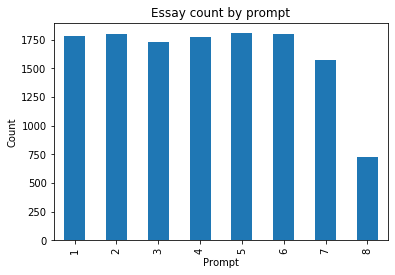

In [32]:
X.groupby('essay_set').agg('count')['essay'].plot.bar()
plt.title('Essay count by prompt')
plt.ylabel('Count')
plt.xlabel('Prompt')
plt.show()

#### Essay length (number of words) distribution by prompt after removing the stop words and punctuation (".", "!", "@" etc.).  Here is a list of stopwords removed from the essay using nltk stopwords. 

["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [33]:
X['tokenized_sents'] = X.apply(lambda row: essay_to_wordlist(row['essay'], remove_stopwords = True), axis=1)
X['sents_length'] = X.apply(lambda row: len(row['tokenized_sents']), axis=1)

#### Average essay length varies from 58-285 words (after removing the stopwords)

In [34]:
X.groupby(['essay_set'])['sents_length'].agg(['min','max', 'mean', 'median'])

,min,max,mean,median
essay_set,,,,
1,3,427,183.833988,181
2,15,524,175.451667,167
3,2,189,52.672654,48
4,1,188,43.473446,39
5,2,217,58.801662,56
6,2,239,82.910556,84
7,1,291,76.685787,69
8,3,515,285.006916,292


#### Lets find the 50, 75 and 90% length stats by essay prompt. 
#### We will use this for setting maxlen parameter later in the models.

In [35]:
X.groupby(['essay_set'])['sents_length'].quantile([0.5, 0.75, 0.90])

essay_set      
1          0.50    181.0
           0.75    222.5
           0.90    265.0
2          0.50    167.0
           0.75    217.0
           0.90    276.0
3          0.50     48.0
           0.75     71.0
           0.90     90.5
4          0.50     39.0
           0.75     59.0
           0.90     79.0
5          0.50     56.0
           0.75     77.0
           0.90     99.0
6          0.50     84.0
           0.75    103.0
           0.90    122.0
7          0.50     69.0
           0.75     98.0
           0.90    134.2
8          0.50    292.0
           0.75    366.0
           0.90    404.0
Name: sents_length, dtype: float64

#### Word count distribution by essay prompt ranges from 200-500 words after cleaning up stopwords and punctuations etc.

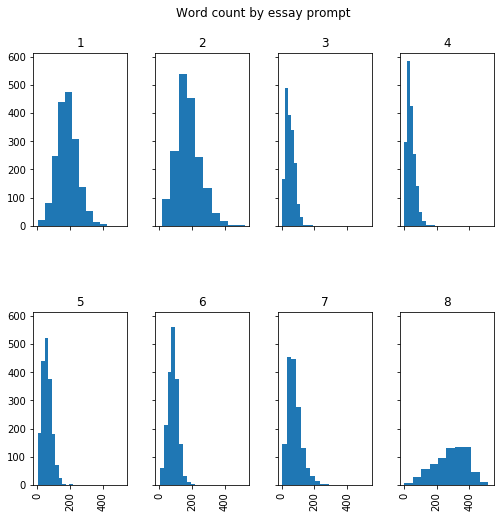

In [36]:
#X.hist(column='sents_length', by='essay', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
X.hist(column='sents_length', by='essay_set', sharex=True, sharey=True, layout=(2, 4), figsize=(8,8)) 
plt.suptitle('Word count by essay prompt')
plt.show()

#### There is a good score correlation to essay length (most of them > 0.7)

In [37]:
X.groupby('essay_set')[['sents_length','domain1_score']].corr()

sents_length  domain1_score
essay_set                                           
1         sents_length       1.000000       0.813735
          domain1_score      0.813735       1.000000
2         sents_length       1.000000       0.673110
          domain1_score      0.673110       1.000000
3         sents_length       1.000000       0.706035
          domain1_score      0.706035       1.000000
4         sents_length       1.000000       0.739430
          domain1_score      0.739430       1.000000
5         sents_length       1.000000       0.811706
          domain1_score      0.811706       1.000000
6         sents_length       1.000000       0.697972
          domain1_score      0.697972       1.000000
7         sents_length       1.000000       0.679424
          domain1_score      0.679424       1.000000
8         sents_length       1.000000       0.533699
          domain1_score      0.533699       1.000000

#### Score distribution for each essay set. Scoring is different for each prompt. It makes sense to train each prompt separately as each essay has differences in grade level, type of essay (narrative, argumentative, source based), and marking differences between each prompt. As mentioned earlier, we will focus on "essay_set == 3"

In [38]:
X.groupby(['essay_set'])['domain1_score'].agg(['min','max', 'mean', 'median'])

,min,max,mean,median
essay_set,,,,
1,2,12,8.528323,8
2,1,6,3.415556,3
3,0,3,1.848204,2
4,0,3,1.432203,1
5,0,4,2.408864,2
6,0,4,2.720000,3
7,2,24,16.062460,16
8,10,60,36.950207,37


#### For this project we will consider "prompt 3" essay (essay_set == 3)
#### This is one of the harder prompts as numerous papers have reported low cohen-kappa scores

In [39]:
X_prompt3 = X[X['essay_set'] == 3]


#### Most samples are scored 1, 2 and 3, and very few zero scores. So, class 0 is unbalanced. 
#### We will use stratified k-fold to ensure the training set contains a balanced class 0 in each fold

In [40]:
X_prompt3.groupby(['domain1_score'])['essay_id'].agg(['count'])

,count
domain1_score,
0,39
1,607
2,657
3,423


#### All models below are using stratified k-fold to keep a balanced representation of classes during training, and evaluation. We have picked maxlen=100 words, as 95% of prompt 3 essays are below 100 words in length. We have picked a vocab size of 4000 words to match the results in the 2 papers listed above.
#### Evaluation is being done with cohen-kappa score (measure of goodness of model's score with human score)

### Training and evaluation of CNN Model with tf-idf representation


In [42]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot

from keras.layers import Embedding, Dense, Dropout, Flatten
from keras.layers import LSTM, Conv1D, MaxPooling1D, AveragePooling1D, TimeDistributed
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Sequential

import numpy as np


skfold = StratifiedKFold(5, True, 1)
results = []
y_pred_list = []
count = 1

#X_prompt = p3_df
X_prompt = X_prompt3
y = X_prompt['domain1_score']
#y = y.values

maxlen = 100
vocab_size = 4000
embedding_dim = 300
keras_tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='UNK')
keras_tokenizer.fit_on_texts(X_prompt['essay'])
encoded_essays = np.array(keras_tokenizer.texts_to_matrix(X_prompt['essay'], mode='tfidf'))
#print(f'encoded_docs size={len(encoded_docs)}, encoded_docs={encoded_docs}')

print(f'Prompt 3')
for traincv, testcv in skfold.split(X_prompt,y):
  print("\n--------Fold {}--------\n".format(count))
  X_test, X_train, y_test, y_train = X_prompt.iloc[testcv], X_prompt.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
  train_essays = X_train['essay']
  test_essays = X_test['essay']
  
  y_train = y_train.values
  y_test = y_test.values
  
  #print(f'y_train={y_train}')
  encoded_essays = encoded_essays.reshape(encoded_essays.shape[0], encoded_essays.shape[1], 1)
  input_train_essays = encoded_essays[traincv]
  input_test_essays = encoded_essays[testcv]
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(vocab_size, 1)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  if (count == 1):  
    model.summary()
  history = model.fit(input_train_essays, y_train, batch_size=64, epochs=20, verbose=0)

  y_pred = model.predict(input_test_essays)
  y_pred = np.argmax(y_pred, axis=1)
    
  # Round y_pred to the nearest integer.
  #y_pred = np.around(y_pred)
    
  # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
  #result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
  result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
  print("Kappa Score: {}".format(result))
  results.append(result)
    
  count += 1
    
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))  
#results = []


Prompt 3

--------Fold 1--------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 3998, 32)          128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1999, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1997, 32)          3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 998, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 31936)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16351744  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)  

#### We see average kappa score of 0.48. The best models have reported scores from 0.695-0.78.
#### Please see these 2 reference papers 
* Incorporating Neural Coherence Features: https://arxiv.org/abs/1711.04981
* A Siamese Bidirectional LSTM Architecture: https://www.mdpi.com/2073-8994/10/12/682


### Lets see if we can improve our kappa scores with CNN+jointly learned embeddings

In [44]:
skfold = StratifiedKFold(5, True, 1)
results = []
y_pred_list = []
count = 1

#X_prompt = p3_df
X_prompt = X_prompt3
y = X_prompt['domain1_score']
#y = y.values

maxlen = 100
vocab_size = 7000
embedding_dim = 300
keras_tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='UNK')
keras_tokenizer.fit_on_texts(X_prompt['essay'])
sequences = keras_tokenizer.texts_to_sequences(X_prompt['essay'])
encoded_essays = sequence.pad_sequences(sequences, maxlen=100, padding='post')

print(f'Prompt 3')
for traincv, testcv in skfold.split(X_prompt, y):
  print("\n--------Fold {}--------\n".format(count))
  X_test, X_train, y_test, y_train = X_prompt.iloc[testcv], X_prompt.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
  train_essays = X_train['essay']
  test_essays = X_test['essay']
  
  y_train = y_train.values
  y_test = y_test.values
  
  #print(f'y_train={y_train}')  
  input_train_essays = encoded_essays[traincv]
  input_test_essays = encoded_essays[testcv]
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  #model.add(Bidirectional(LSTM(300, dropout=0.4, recurrent_dropout=0.4), merge_mode='ave'))#, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(300, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(150, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  if (count == 1):
    model.summary()
  history = model.fit(input_train_essays, y_train, batch_size=64, epochs=20, verbose=0)

  y_pred = model.predict(input_test_essays)
  y_pred = np.argmax(y_pred, axis=1)
  matrix = confusion_matrix(y_test, y_pred)
  print(matrix)
    
  # Round y_pred to the nearest integer.
  #y_pred = np.around(y_pred)
    
  # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
  #result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
  result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
  print("Kappa Score: {}".format(result))
  results.append(result)
    
  count += 1
    
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))  


Prompt 3

--------Fold 1--------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          2100000   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 98, 32)            28832     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 47, 32)            3104      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 736)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)  

#### Scores improved from 0.48 to 0.51 with jointly learned embeddings. Confusion matrix show large number of errors for a score of 0. This is because our training sample set for zero scores is low. Let's see if we can improve the model with data augmentation

### With data augmentation

### I have leveraged the data augmentation code from https://github.com/jasonwei20/eda_nlp?source=post_page---------------------------

### Please see this blog post https://towardsdatascience.com/these-are-the-easiest-data-augmentation-techniques-in-natural-language-processing-you-can-think-of-88e393fd610

It describes the following techniques, and our model uses all of them:
* Synonym Replacement (SR): Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.
* Random Insertion (RI): Find a random synonym of a random word in the sentence that is not a stop word. Insert that synonym into a random position in the sentence. Do this n times.
* Random Swap (RS): Randomly choose two words in the sentence and swap their positions. Do this n times.
* Random Deletion (RD): For each word in the sentence, randomly remove it with probability p.

Lets get the zero score samples from prompt 3 essay set

In [45]:
p3_df = X_prompt3[['domain1_score', 'essay']]
p3_df_zeroscore = p3_df[p3_df['domain1_score'] == 0]
p3_df_zeroscore.reset_index(inplace=True)
p3_df_zeroscore = p3_df_zeroscore[['domain1_score', 'essay']]
p3_df_zeroscore.to_csv(DATA_DIR + '/essay.tsv', 
             sep='\t', index=False, header=False)

### Data Augmentation Routines from Jason Wei and Kai Zou

In [46]:
# Jason Wei and Kai Zou

#number of augmented sentences to generate per original sentence
num_aug = 9 #default
#how much to change each sentence
alpha = 0.1#default



#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text

def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################


def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1
	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	#sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	#ri
	for _ in range(num_new_per_technique):
		a_words = random_insertion(words, n_ri)
		augmented_sentences.append(' '.join(a_words))

	#rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(' '.join(a_words))

	#rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences



#generate more data with standard augmentation
def gen_eda(train_orig, output_file, alpha, num_aug=9):

    writer = open(output_file, 'w')
    lines = open(train_orig, 'r').readlines()

    for i, line in enumerate(lines):
        parts = line[:-1].split('\t')
        label = parts[0]
        sentence = parts[1]
        aug_sentences = eda(sentence, alpha_sr=alpha, alpha_ri=alpha, alpha_rs=alpha, p_rd=alpha, num_aug=num_aug)
        for aug_sentence in aug_sentences:
            writer.write(label + "\t" + aug_sentence + '\n')

    writer.close()
    print("generated augmented sentences with eda for " + train_orig + " to " + output_file + " with num_aug=" + str(num_aug))


#generate augmented sentences and output into a new file "eda_essay.tsv"
output = DATA_DIR + '/eda_essay.tsv'
input = DATA_DIR + '/essay.tsv'
print(f'input={input}')
print(f'output={output}')

gen_eda(input, output, alpha=alpha, num_aug=num_aug)

input=./data/essay.tsv
output=./data/eda_essay.tsv
generated augmented sentences with eda for ./data/essay.tsv to ./data/eda_essay.tsv with num_aug=9


lets read the data augmented file "eda_essay.tsv" which contains augmented samples. 


In [47]:
colnames=['domain1_score', 'essay']
p3_aug_df = pd.read_csv(DATA_DIR + '/eda_essay.tsv',
                       sep='\t', names=colnames, header=None)

We have increased our samples from 39 to 390 zero scored samples

In [49]:
p3_aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 2 columns):
domain1_score    390 non-null int64
essay            390 non-null object
dtypes: int64(1), object(1)
memory usage: 6.2+ KB


Lets add the augmented zero scored samples to original data set 

In [50]:
X_nonzeroscore = X_prompt3[X_prompt3['domain1_score'] != 0]
X_nonzeroscore.info()
p3_df_nonzeroscore = X_nonzeroscore[['domain1_score', 'essay']]
p3_df_nonzeroscore.reset_index(inplace=True)
p3_df_nonzeroscore = p3_df_nonzeroscore[['domain1_score', 'essay']]
p3_df_nonzeroscore.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687 entries, 3583 to 5308
Data columns (total 6 columns):
essay_id           1687 non-null int64
essay_set          1687 non-null int64
essay              1687 non-null object
domain1_score      1687 non-null int64
tokenized_sents    1687 non-null object
sents_length       1687 non-null int64
dtypes: int64(4), object(2)
memory usage: 92.3+ KB


,domain1_score,essay
0,1,The features of the setting affect the cyclist...
1,2,The features of the setting affected the cycli...
2,1,Everyone travels to unfamiliar places. Sometim...
3,1,I believe the features of the cyclist affected...
4,2,The setting effects the cyclist because of the...


In [52]:
p3_df = pd.concat([p3_df_nonzeroscore, p3_aug_df], axis = 0)
p3_df.groupby(['domain1_score']).agg(['count'])

,essay
,count
domain1_score,
0,390
1,607
2,657
3,423


### Lets retrain our CNN model with tf-idf representation with augmented data

In [53]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot

from keras.layers import Embedding, Dense, Dropout, Flatten
from keras.layers import LSTM, Conv1D, MaxPooling1D, AveragePooling1D, TimeDistributed
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Sequential

import numpy as np


skfold = StratifiedKFold(5, True, 1)
results = []
y_pred_list = []
count = 1

X_prompt = p3_df
y = X_prompt['domain1_score']
#y = y.values

maxlen = 100
vocab_size = 4000
embedding_dim = 300
keras_tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='UNK')
keras_tokenizer.fit_on_texts(X_prompt['essay'])
encoded_essays = np.array(keras_tokenizer.texts_to_matrix(X_prompt['essay'], mode='tfidf'))
#print(f'encoded_docs size={len(encoded_docs)}, encoded_docs={encoded_docs}')

print(f'Prompt 3')
for traincv, testcv in skfold.split(X_prompt,y):
  print("\n--------Fold {}--------\n".format(count))
  X_test, X_train, y_test, y_train = X_prompt.iloc[testcv], X_prompt.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
  train_essays = X_train['essay']
  test_essays = X_test['essay']
  
  y_train = y_train.values
  y_test = y_test.values
  
  #print(f'y_train={y_train}')
  encoded_essays = encoded_essays.reshape(encoded_essays.shape[0], encoded_essays.shape[1], 1)
  input_train_essays = encoded_essays[traincv]
  input_test_essays = encoded_essays[testcv]
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(vocab_size, 1)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  if (count == 1):  
    model.summary()
  history = model.fit(input_train_essays, y_train, batch_size=64, epochs=20, verbose=0)

  y_pred = model.predict(input_test_essays)
  y_pred = np.argmax(y_pred, axis=1)
    
  # Round y_pred to the nearest integer.
  #y_pred = np.around(y_pred)
    
  # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
  #result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
  result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
  print("Kappa Score: {}".format(result))
  results.append(result)
    
  count += 1
    
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))  
#results = []


Prompt 3

--------Fold 1--------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 3998, 32)          128       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 1999, 32)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1997, 32)          3104      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 998, 32)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 31936)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               16351744  
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)  

### We see a significant improvement in kappa from 0.48 to 0.76 with data augmention

### Lets check our results of CNN model with embeddings and augmented data

In [55]:
skfold = StratifiedKFold(5, True, 1)
results = []
y_pred_list = []
count = 1

X_prompt = p3_df
y = X_prompt['domain1_score']
#y = y.values

maxlen = 100
vocab_size = 7000
embedding_dim = 300
keras_tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='UNK')
keras_tokenizer.fit_on_texts(X_prompt['essay'])
sequences = keras_tokenizer.texts_to_sequences(X_prompt['essay'])
encoded_essays = sequence.pad_sequences(sequences, maxlen=100, padding='post')

print(f'Prompt 3')
for traincv, testcv in skfold.split(X_prompt, y):
  print("\n--------Fold {}--------\n".format(count))
  X_test, X_train, y_test, y_train = X_prompt.iloc[testcv], X_prompt.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
  train_essays = X_train['essay']
  test_essays = X_test['essay']
  
  y_train = y_train.values
  y_test = y_test.values
  
  #print(f'y_train={y_train}')  
  input_train_essays = encoded_essays[traincv]
  input_test_essays = encoded_essays[testcv]
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  #model.add(Bidirectional(LSTM(300, dropout=0.4, recurrent_dropout=0.4), merge_mode='ave'))#, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(300, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(150, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  if (count == 1):
    model.summary()
  history = model.fit(input_train_essays, y_train, batch_size=64, epochs=20, verbose=0)

  y_pred = model.predict(input_test_essays)
  y_pred = np.argmax(y_pred, axis=1)
  matrix = confusion_matrix(y_test, y_pred)
  print(matrix)
    
  # Round y_pred to the nearest integer.
  #y_pred = np.around(y_pred)
    
  # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
  #result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
  result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
  print("Kappa Score: {}".format(result))
  results.append(result)
    
  count += 1
    
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))  


Prompt 3

--------Fold 1--------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          2100000   
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 98, 32)            28832     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 47, 32)            3104      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 736)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 300)  

Kappa Scores improved from 0.51 (without augentation) to 0.756 (with augmentation).
So, data augmentation techniques can be effective with unbalanced classes or small sample sizes (which was the case here). However, caution is warranted when extrapolating/generalizing the results. Since data augmentation takes the same essay, and creates a variation, the models learn the variations. However with a new essay, the results may not improve as much. In such cases, the 2 papers listed show promising approaches to better understand the logical progression and semantic relatedness to the main prompt. 